This script calculates predefined audio features, spectrograms and cepstral coefficients from audio data and exports them to a csv.

In [10]:
import glob
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns
import random
from scipy.stats import kurtosis, skew, gmean
from scipy import signal, fft
from statsmodels.stats.weightstats import DescrStatsW
import parselmouth
from skimage.transform import resize
import json
from torchaudio import transforms
from torch import tensor

In [11]:
random.seed(42)

In [12]:
DATAPATH = "/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections"
clip_paths = glob.glob(DATAPATH+"/*.wav")

In [13]:
len(clip_paths)

7357

##### Inspect single call

In [14]:
i = 200
N_FFT = 512
HOP_OVERLAP = 9
TOP_dB_SILENCE = 35
NUM_CEPS = 16

In [15]:
vocalization, sr = librosa.load(clip_paths[i], sr=None)

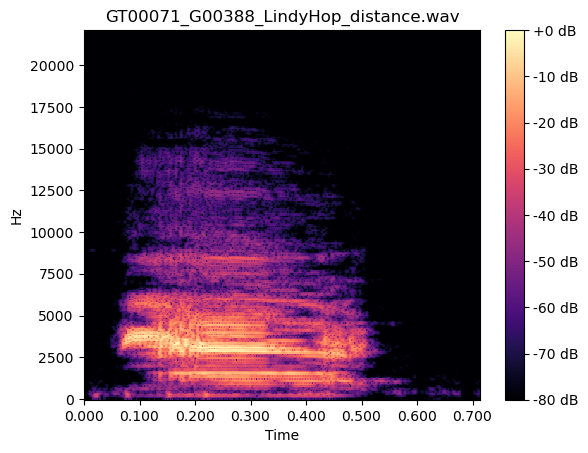

In [16]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(vocalization, n_fft=N_FFT, hop_length=(N_FFT//HOP_OVERLAP))), ref=np.max), sr=sr, hop_length=(N_FFT//HOP_OVERLAP), x_axis='time', y_axis='linear', ax=ax)
ax.set(title=clip_paths[i].split("/")[-1])
fig.colorbar(img, ax=ax, format="%+2.f dB")

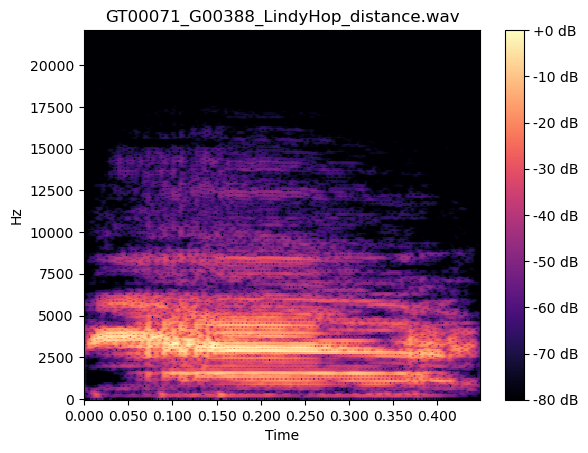

In [17]:
# trim trailing silences using db threshold, discard second entry, that holds indices
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(librosa.effects.trim(vocalization, top_db=TOP_dB_SILENCE, frame_length=N_FFT, hop_length=(N_FFT//HOP_OVERLAP))[0], n_fft=N_FFT, hop_length=(N_FFT//HOP_OVERLAP))), ref=np.max), sr=sr, hop_length=(N_FFT//HOP_OVERLAP), x_axis='time', y_axis='linear', ax=ax)
ax.set(title=clip_paths[i].split("/")[-1])
fig.colorbar(img, ax=ax, format="%+2.f dB")

##### Process clips and write to dataframe
On the waveform: 
- trim trailing silences using a threshold value of TOP_dB_SILENCE
- peak normalize signals
Because some calls are more quiet than others, this emphasizes the remaining noise more on e.g. contact calls.

Therefore I do the following:
After applying stft (for N_FFT and HOP_OVERLAP value see top of the script)
1) min_max_scale the spectrogram values to range from 0 to 1:

$$X = \frac{X - X_{min}}{X_{max} - X_{min}}$$

2) power scale the spectrogram values depending on the median:
        The median will be higher with higer noise values. I use this to raise the gamma value when the power scaling accordingly:
$$X_{scaled} = X^{\frac{1}{\gamma}}$$

with $\gamma = \left\{ 
  \begin{array}{ c l }
    0.8-median(X) & \quad \textrm{if } x \geq 0.5 \\
    0.5                 & \quad \textrm{otherwise}
  \end{array}
\right.$

Subtracting the median from a minimum scaling gamma of 0.8 ensures higher scaling effects with higher median values.
This approach has the limitation that longer calls, those with less harmonicity and a more broadband power distribution will be scaled to a higher effect. Because the audio features are calculated based on the original waveform, this effect is limited to spectrograms. 

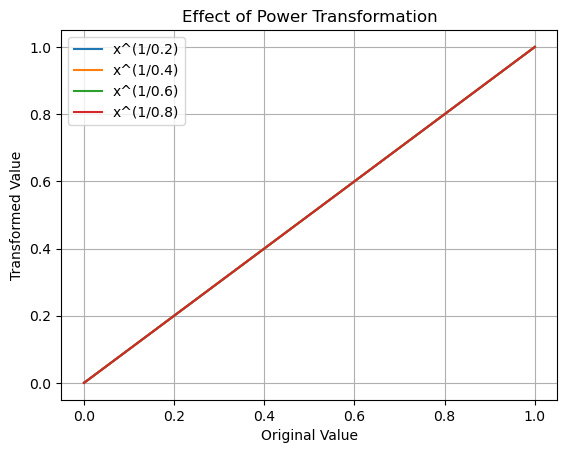

In [18]:
# Simulate values in [0, 1]
y = np.linspace(0, 1, 100)
gamma_values = [.2, .4, .6, .8]

for gamma in gamma_values:
    # power transformation
    y = y**(1/gamma)
    plt.plot(y, y, label=f"x^(1/{gamma})")
    
plt.legend()
plt.grid()
plt.title("Effect of Power Transformation")
plt.xlabel("Original Value")
plt.ylabel("Transformed Value")
plt.show()

In [19]:
def _min_max_scale(data):
    # Normalizes to values between 0 and 1
    return (data - data.min()) / (data.max() - data.min())
    
def _peak_normalization(data):
    # from biosound package: https://github.com/theunissenlab/BioSoundTutorial/blob/master/BioSound1.ipynb
    return np.array((data / np.max(np.abs(data))), np.float32)

def _to_pixel_and_cut(spectrogram):
    spectrogram = _min_max_scale(spectrogram)
    return spectrogram[:int(len(spectrogram)*0.7), :] # cut out higher frequencies where no power is left

def _lin_spectrogram(waveform, plot=False):
    spectrogram = np.abs(librosa.stft(waveform, n_fft=N_FFT, hop_length=(N_FFT//HOP_OVERLAP)))
    spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)    
    if plot:
        fig, ax = plt.subplots()
        ax.matshow(_to_pixel_and_cut(spectrogram), origin="lower", cmap="magma")
        ax.axis("off")
        ax.set(title=clip_paths[i].split("/")[-1])
    return spectrogram

def _emphasized_spectrogram(waveform, plot=False):
    # transform to power spectrogram, min-max-scale, cut off higer frequencies, deemphasize noise relative to median
    spectrogram = np.abs(librosa.stft(waveform, n_fft=N_FFT, hop_length=(N_FFT//HOP_OVERLAP)))
    spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)
    # Normalize to range (0, 1)
    spectrogram = _min_max_scale(spectrogram)
    spectrogram = spectrogram**(1/(.8-np.median(spectrogram) if .8-np.median(spectrogram)>=.5 else .5))
    if plot:
        fig, ax = plt.subplots()
        ax.matshow(_to_pixel_and_cut(spectrogram), origin="lower", cmap="magma")
        ax.axis("off")
        ax.set(title=clip_paths[i].split("/")[-1])
    return spectrogram

def _process_waveform(waveform):
    trimmed_waveform = librosa.effects.trim(waveform, top_db=TOP_dB_SILENCE, frame_length=N_FFT, hop_length=(N_FFT//HOP_OVERLAP))[0]
    normalized_waveform = _peak_normalization(trimmed_waveform)
    return normalized_waveform

In [20]:
def _lfccs(waveform, sr, plot=False):
    lfcc_transform = transforms.LFCC(
        sample_rate=sr,
        n_lfcc=NUM_CEPS,
        speckwargs={"n_fft": N_FFT, "hop_length": N_FFT//HOP_OVERLAP, "center": False}
    )
    waveform_tensor = tensor(waveform).unsqueeze(0)
    lfcc = lfcc_transform(waveform_tensor)
    lfcc = lfcc.squeeze(0).numpy() # to 2D numpy array

    if plot:
        fig, ax = plt.subplots()
        ax.matshow(lfcc, origin="lower", cmap="magma")
        ax.axis("off")
        ax.set(title=clip_paths[i].split("/")[-1])
    return lfcc

0.16912842

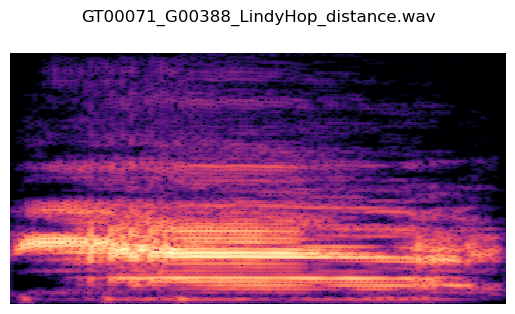

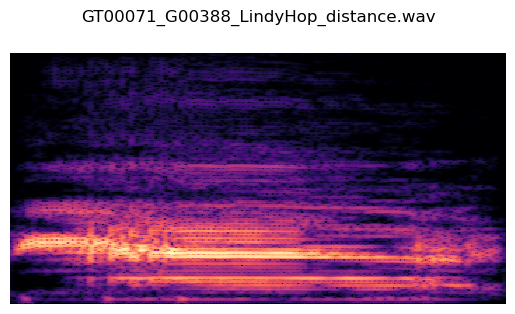

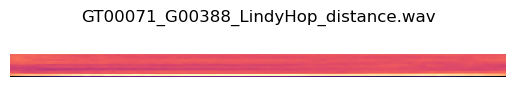

In [21]:
_lin_spectrogram(_process_waveform(vocalization), plot=True)
_emphasized_spectrogram(_process_waveform(vocalization), plot=True)
_lfccs(_process_waveform(vocalization), sr=sr, plot=True)
np.max(np.abs(vocalization))

In [22]:
calls_df = pd.DataFrame(columns=["track_ID", "clip_ID", "goose_ID", "call_type", "waveform", "sr", "filepath", "spectrogram", "lfccs", "peak"])
for clip_path in tqdm(clip_paths):
    waveform, sr = librosa.load(clip_path, sr=None)
    peak = np.max(np.abs(waveform))
    waveform = _process_waveform(waveform) # trim silence and peak normalize
    if np.isnan(waveform).any():
        print(clip_path+" contains NA values")
        continue
    array = _emphasized_spectrogram(waveform) # transform to power spectrogram, min-max-scale, cut off higer frequencies, deemphasize noise relative to median
    lfccs = _lfccs(waveform, sr=sr)
    filename = clip_path.split("/")[-1].split(".")[0]
    calls_df.loc[len(calls_df)] = [filename.split("_")[0], filename.split("_")[1], filename.split("_")[2], filename.split("_")[3], waveform, sr, clip_path, array, lfccs, peak]

 32%|███▏      | 2344/7357 [00:16<00:34, 143.61it/s]/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_2193/3129789181.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((data / np.max(np.abs(data))), np.float32)
 32%|███▏      | 2380/7357 [00:16<00:32, 155.52it/s]

/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections/GT00984_G12682_Bregenz_triumph.wav contains NA values


 87%|████████▋ | 6414/7357 [00:51<00:07, 122.35it/s]/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_2193/3129789181.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((data / np.max(np.abs(data))), np.float32)
 88%|████████▊ | 6439/7357 [00:51<00:08, 112.52it/s]

/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections/GT00984_G12602_Kruemmel_triumph.wav contains NA values


/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_2193/3129789181.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((data / np.max(np.abs(data))), np.float32)
 88%|████████▊ | 6464/7357 [00:51<00:08, 109.35it/s]

/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections/GT00984_G12763_Bregenz_unknown.wav contains NA values


100%|██████████| 7357/7357 [01:00<00:00, 122.12it/s]


In [23]:
len(calls_df)

7354

In [24]:
calls_df.head()

,track_ID,clip_ID,goose_ID,call_type,waveform,sr,filepath,spectrogram,lfccs,peak
0,GT00780,G11666,Lando,recruitment,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.019933237, 0.060814682, 0.073473...","[[-384.75204, -391.9265, -395.2193, -387.9781,...",0.009796
1,GT00772,G11510,Burglar,recruitment,"[-0.00084985833, 0.00084985833, 0.0028328612, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.032295033, 0.025360242, 0.0, 0.0, 0.0, 0.0...","[[-335.15942, -320.47253, -313.74426, -309.589...",0.107727
2,GT00795,G11994,EinStein,contact,"[0.004903678, 0.0052539404, 0.0038528896, 0.00...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.028061852, 0.015824763, 0.017440086, 0.045...","[[-391.72293, -381.86548, -371.19098, -360.817...",0.087128
3,GT00447,G04128,BruceSpringsteen,departure,"[0.00017799929, -0.00035599858, -0.001245995, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0150192985, 0.0094179325, 0.00040014132, 0...","[[-349.48306, -330.95694, -313.1729, -300.9760...",0.171448
4,GT00775,G11567,Anthony,recruitment,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00143884...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0033818383, 0.075...","[[-391.88184, -385.90564, -381.499, -375.24374...",0.021210


In [25]:
calls_df.loc[calls_df["peak"].idxmin()]

track_ID                                                 GT00984
clip_ID                                                   G12594
goose_ID                                                Kruemmel
call_type                                                triumph
waveform       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sr                                                         44100
filepath       /Users/lenagies/Desktop/Master/Thesis/geese/da...
spectrogram    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
lfccs          [[-460.7413, -460.7413, -460.7413, -460.7413, ...
peak                                                    0.000275
Name: 4449, dtype: object

In [26]:
# discard calls with peak values lower than 0.001 and higher than 0.99
calls_df = calls_df[calls_df["peak"]>=0.0015]
calls_df = calls_df[calls_df["peak"]<=0.99]

/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_2193/2393745769.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'recruitment'),
  Text(1, 0, 'contact'),
  Text(2, 0, 'departure'),
  Text(3, 0, 'distance'),
  Text(4, 0, 'unknown'),
  Text(5, 0, 'triumph'),
  Text(6, 0, 'hiss'),
  Text(7, 0, 'alarm'),
  Text(8, 0, 'loud'),
  Text(9, 0, 'greeting'),
  Text(10, 0, 'rolling')])

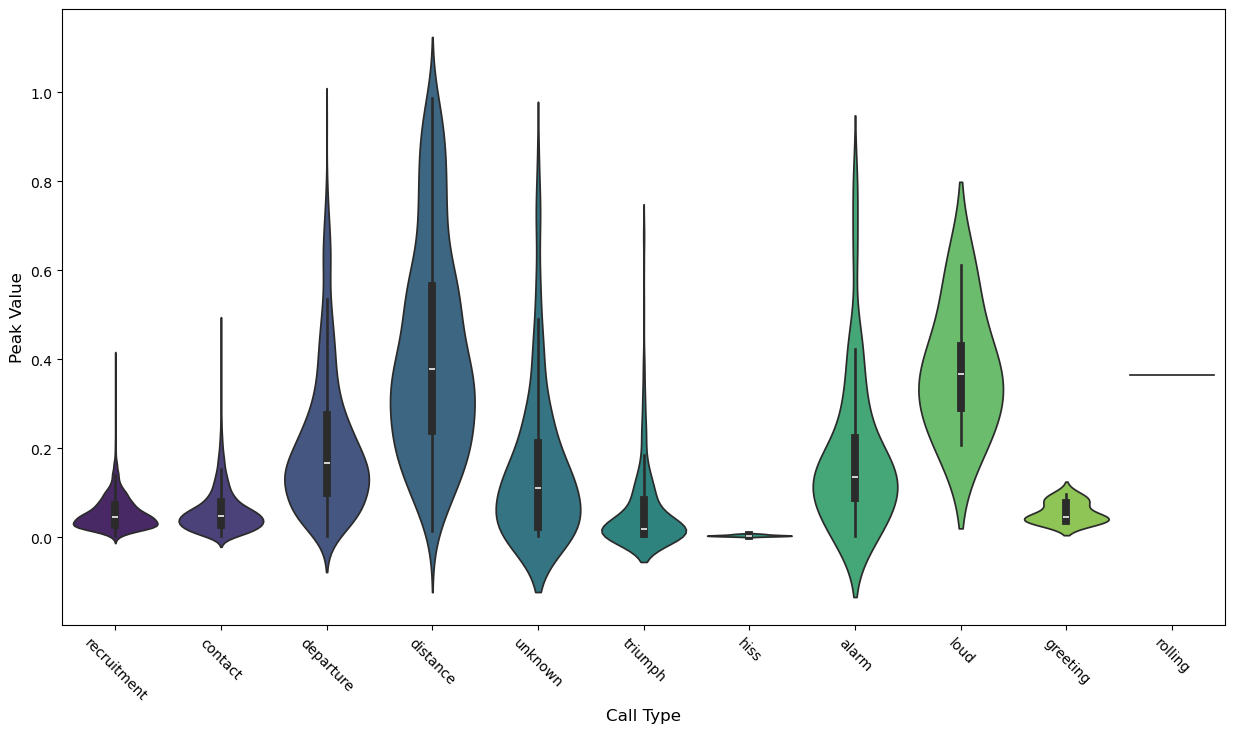

In [27]:
plt.figure(figsize=(15, 8))
sns.violinplot(
    data=calls_df,
    x="call_type",
    y="peak",
    palette="viridis",
    density_norm="width" 
)

plt.xlabel("Call Type", fontsize=12)
plt.ylabel("Peak Value", fontsize=12)

plt.xticks(rotation=-45)

/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_2193/671820867.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  hist = sns.histplot(


[]

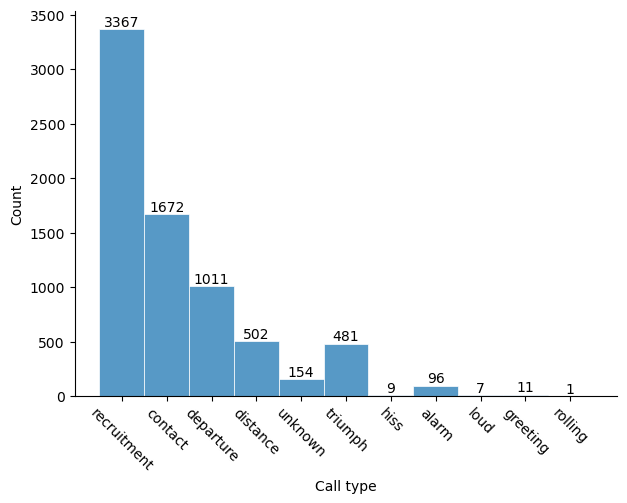

In [28]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

hist = sns.histplot(
    calls_df,
    x="call_type",
    multiple="stack",
    palette="viridis",
    edgecolor="1",
    linewidth=.5,
)

plt.xticks(rotation=-45)
ax.set_xlabel("Call type")

# Add counts
for p in hist.patches:
    height = p.get_height()
    y = p.get_x() + p.get_width() / 2
    ax.annotate(f'{int(height)}', (y, height), ha='center', va='bottom')
    
plt.plot()

Discard vocalizations labelled as hisses, loud, greeting and rolling calls. These labels are not used in the current protocol (and we have too few hisses).

In [29]:
# discard loud, greeting and rolling calls
calls_df = calls_df[~calls_df['call_type'].isin(['loud', 'greeting', 'rolling', 'hiss'])]

/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_2193/671820867.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  hist = sns.histplot(


[]

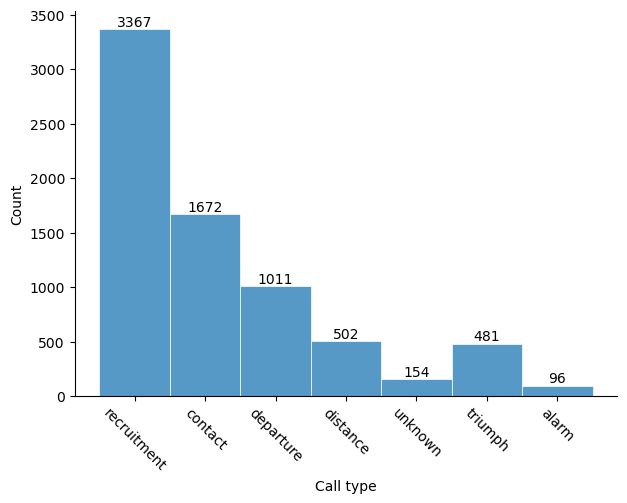

In [30]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

hist = sns.histplot(
    calls_df,
    x="call_type",
    multiple="stack",
    palette="viridis",
    edgecolor="1",
    linewidth=.5,
)

plt.xticks(rotation=-45)
ax.set_xlabel("Call type")

# Add counts
for p in hist.patches:
    height = p.get_height()
    y = p.get_x() + p.get_width() / 2
    ax.annotate(f'{int(height)}', (y, height), ha='center', va='bottom')
    
plt.plot()

Plot the durations of the calls

In [31]:
calls_df['duration'] = calls_df.apply(lambda row: len(row['waveform']) / row['sr'], axis=1)
calls_df['log_duration'] = calls_df.apply(lambda row: np.log(row['duration']), axis=1)
calls_df.head()

,track_ID,clip_ID,goose_ID,call_type,waveform,sr,filepath,spectrogram,lfccs,peak,duration,log_duration
0,GT00780,G11666,Lando,recruitment,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.019933237, 0.060814682, 0.073473...","[[-384.75204, -391.9265, -395.2193, -387.9781,...",0.009796,0.102857,-2.274414
1,GT00772,G11510,Burglar,recruitment,"[-0.00084985833, 0.00084985833, 0.0028328612, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.032295033, 0.025360242, 0.0, 0.0, 0.0, 0.0...","[[-335.15942, -320.47253, -313.74426, -309.589...",0.107727,0.100998,-2.292657
2,GT00795,G11994,EinStein,contact,"[0.004903678, 0.0052539404, 0.0038528896, 0.00...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.028061852, 0.015824763, 0.017440086, 0.045...","[[-391.72293, -381.86548, -371.19098, -360.817...",0.087128,0.092698,-2.378404
3,GT00447,G04128,BruceSpringsteen,departure,"[0.00017799929, -0.00035599858, -0.001245995, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0150192985, 0.0094179325, 0.00040014132, 0...","[[-349.48306, -330.95694, -313.1729, -300.9760...",0.171448,0.160385,-1.830175
4,GT00775,G11567,Anthony,recruitment,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00143884...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0033818383, 0.075...","[[-391.88184, -385.90564, -381.499, -375.24374...",0.021210,0.088889,-2.420368


/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_2193/1274155072.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'recruitment'),
  Text(1, 0, 'contact'),
  Text(2, 0, 'departure'),
  Text(3, 0, 'distance'),
  Text(4, 0, 'unknown'),
  Text(5, 0, 'triumph'),
  Text(6, 0, 'alarm')])

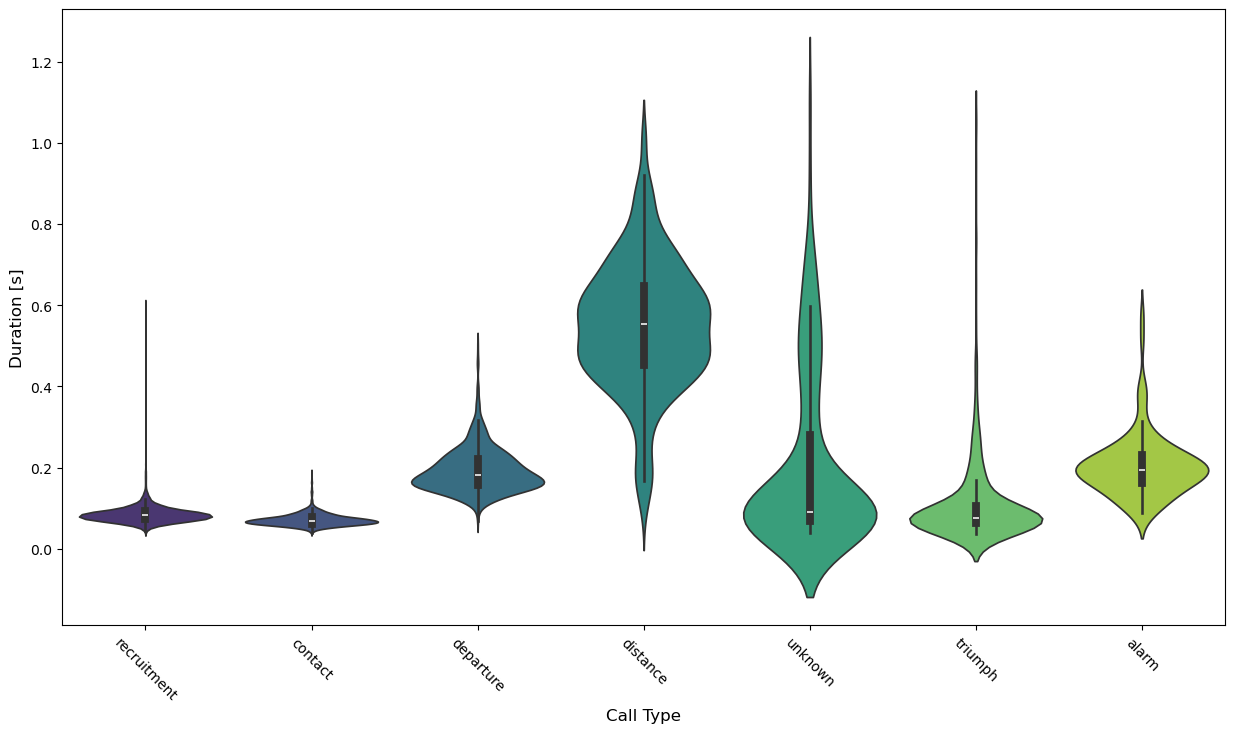

In [32]:
plt.figure(figsize=(15, 8))
sns.violinplot(
    data=calls_df,
    x="call_type",
    y="duration",
    palette="viridis",
    density_norm="width" 
)

plt.xlabel("Call Type", fontsize=12)
plt.ylabel("Duration [s]", fontsize=12)
plt.xticks(rotation=-45)

In [33]:
calls_df.loc[calls_df["duration"].idxmin()]

track_ID                                                  GT00984
clip_ID                                                    G12589
goose_ID                                                  Oberlix
call_type                                                 triumph
waveform        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
sr                                                          44100
filepath        /Users/lenagies/Desktop/Master/Thesis/geese/da...
spectrogram     [[0.0, 0.0, 0.010149959, 0.024581956, 0.039093...
lfccs           [[-255.19865, -235.2551, -219.09735, -205.1332...
peak                                                     0.003204
duration                                                 0.036825
log_duration                                            -3.301568
Name: 569, dtype: object

##### Log scale the times for spectrograms and lfccs
Because the call durations vary substantially, we will log scale the spectrograms before padding to the longest call:

In [34]:
longest_call_total = calls_df.loc[calls_df["duration"].idxmax()]

# take the longest call of 99.7th percentile for max length
filtered_by_percentile = calls_df.loc[calls_df["duration"] >= np.quantile(calls_df["duration"], 0.997)]
longest_call_quantile = filtered_by_percentile.loc[filtered_by_percentile["duration"].idxmin()]
max_bins_spectro = len(longest_call_quantile["spectrogram"][1])
max_bins_lfcc = longest_call_total["lfccs"].shape[1]

max_log_duration = longest_call_total["log_duration"]
max_duration_seconds = longest_call_total["duration"]
#max_bins = len(longest_call_total["spectrogram"][1])
shortest_call = calls_df.loc[calls_df["duration"].idxmin()]

min_log_duration = shortest_call["log_duration"]
min_duration_seconds = shortest_call["duration"]

# Compute log scaled target length for the waveform
calls_df["normalized_log_length"] = calls_df.apply(lambda row: (row["log_duration"]-min_log_duration)/(max_log_duration-min_log_duration), axis=1)
calls_df["log_target_duration"] = calls_df.apply(lambda row: row["normalized_log_length"]*(max_duration_seconds-min_duration_seconds)+min_duration_seconds, axis=1)

# sanity check
print(calls_df.loc[calls_df["duration"].idxmin()]["log_target_duration"], min_duration_seconds)
print(calls_df.loc[calls_df["duration"].idxmax()]["log_target_duration"], max_duration_seconds)


# resize spectrogram to match the log scaled target size, reduce to a quarter of the size to avoid too much aliasing when resizing
def _resize_array(array, original_duration, target_duration, spectrogram):
    if spectrogram:
        array = _to_pixel_and_cut(array)
    # else:
    #     array = _min_max_scale(array)
        
    if array is None or len(array) == 0:
        print("Empty or None array")
        return None
    
    if np.isnan(array).any():
        print("Array contains NaN values")
        return None

    bin_size_s = original_duration / len(array[1])
    target_bins_signal = int(target_duration / bin_size_s)

    try:
        # Resample array to match the target length
        if spectrogram: # reduce to a quarter of the size to avoid aliasing when rescaling to log time and for more effective processing past this point
            resized_array = resize(array, (array.shape[0] // 4, target_bins_signal // 4), anti_aliasing=False)
        else:
            resized_array = resize(array, (array.shape[0], target_bins_signal // 4), anti_aliasing=False) # not reducing coefficient resolution, but time resolution
        if np.isnan(resized_array).any():
            print("NaN in resampled array")
            return None
        
    except Exception as e:
        print(f"Error during resampling: {e}")
        return None
    
    return resized_array, target_bins_signal
    
# Resample and pad spectrograms, these are downsampled to a quarter of the resolution to avoid aliasing when rescaling to log time and for more effective processing past this point
def rescale_and_pad(array, original_duration, target_duration, target_bins_total, spectrogram=True):
    resized_array, target_bins_signal = _resize_array(array, original_duration, target_duration, spectrogram)

    # padding
    total_padding = target_bins_total // 4 - target_bins_signal // 4

    # if above 99th percentile - cut outer bins
    if total_padding < 0:
        return resized_array[:, :-np.abs(total_padding)] # cut bins on the right because reverb promotes trailing silence in clips

    left_padding = total_padding // 2
    right_padding = total_padding - left_padding
    padded_spectrogram = np.pad(resized_array, [(0, 0), (left_padding, right_padding)], "constant", constant_values=0)
    
    if np.isnan(padded_spectrogram).any():
        print("NaN in padded spectrogram")
        return None
    
    return padded_spectrogram


# Apply transformation to each spectrogram
calls_df["log_padded_spectrogram"] = calls_df.apply(
    lambda row: rescale_and_pad(
        row["spectrogram"],
        row["duration"],
        row["log_target_duration"],
        max_bins_spectro
    ),
    axis=1
)

# Apply transformation to lfccs
calls_df["log_padded_lfccs"] = calls_df.apply(
    lambda row: rescale_and_pad(
        row["lfccs"],
        row["duration"],
        row["log_target_duration"],
        max_bins_lfcc,
        spectrogram=False
    ),
    axis=1
)

0.036825396825396824 0.036825396825396824
1.1034920634920635 1.1034920634920635


In [35]:
calls_df[calls_df.isna().any(axis=1)]

,track_ID,clip_ID,goose_ID,call_type,waveform,sr,filepath,spectrogram,lfccs,peak,duration,log_duration,normalized_log_length,log_target_duration,log_padded_spectrogram,log_padded_lfccs


Plot log scaled lengths and rescaled length as sanity check

[]

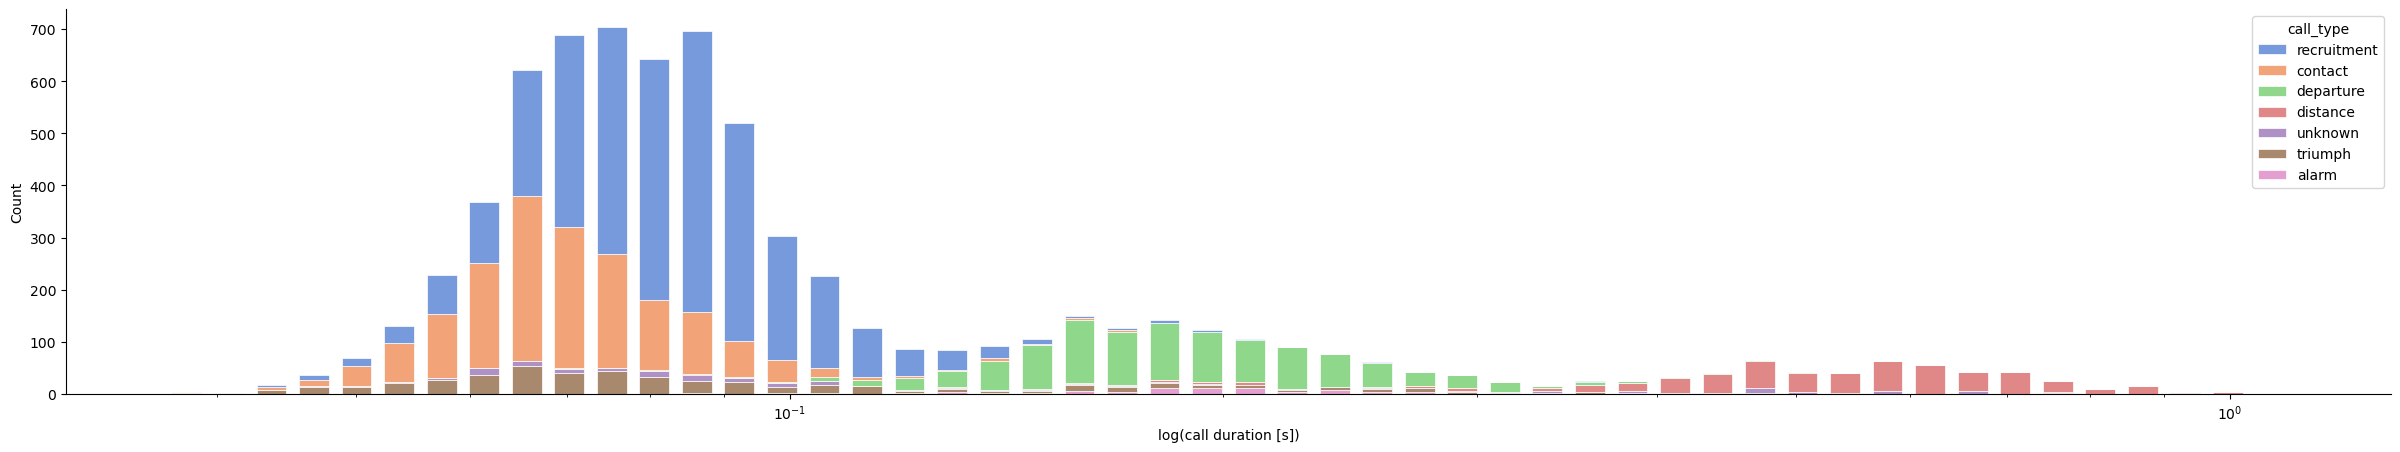

In [36]:
f, ax = plt.subplots(figsize=(30, 5))
sns.despine(f)

sns.histplot(
    calls_df,
    x="duration",
    multiple="stack",
    hue="call_type",
    palette="muted",
    edgecolor="1",
    linewidth=.5,
    shrink=.7,
    bins=50,
    log_scale=True
)
ax.set_xlabel("log(call duration [s])")
plt.plot()

[]

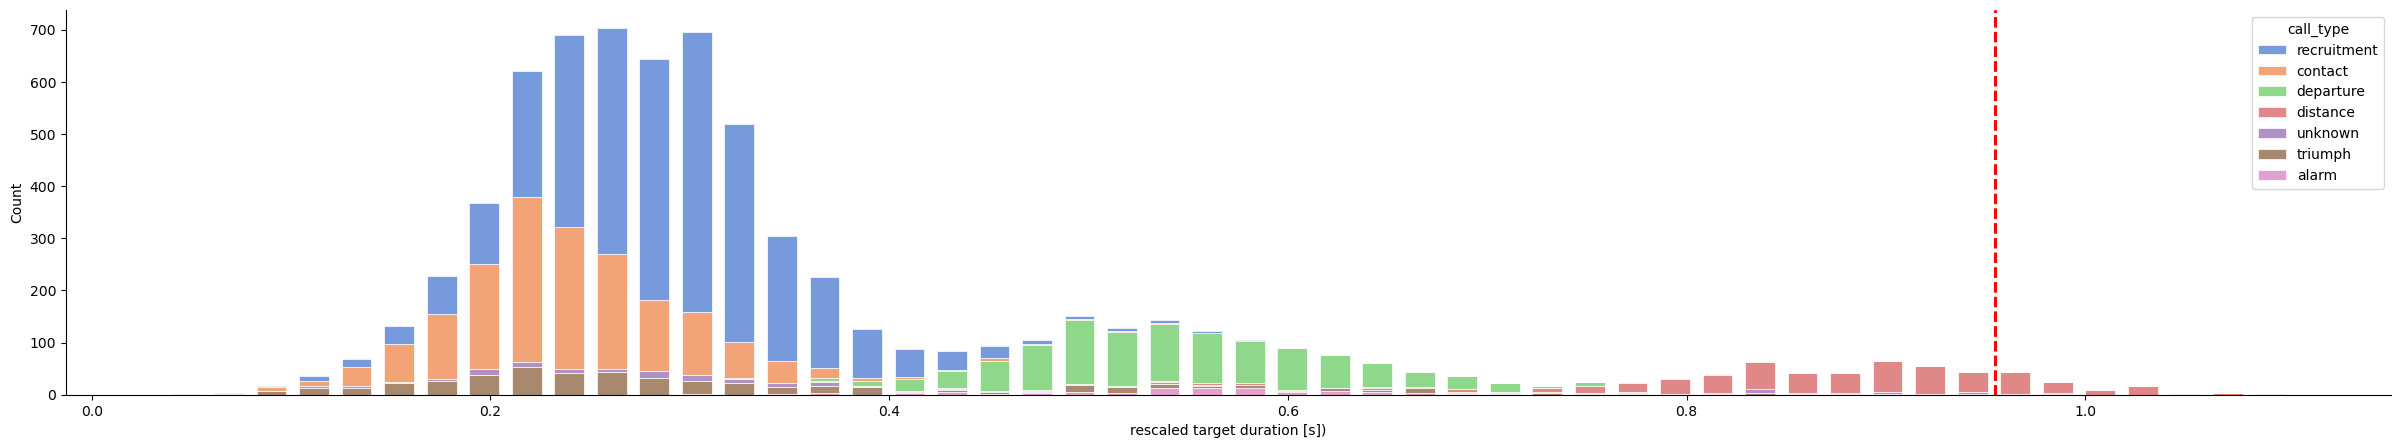

In [37]:
f, ax = plt.subplots(figsize=(30, 5))
sns.despine(f)

histplot = sns.histplot(
    calls_df,
    x="log_target_duration",
    multiple="stack",
    hue="call_type",
    palette="muted",
    edgecolor="1",
    linewidth=.5,
    shrink=.7,
    bins=50,
    ax=ax
)
ax.set_xlabel("rescaled target duration [s])")


quantile = np.quantile(calls_df["duration"], 0.999)
filtered_by_percentile = calls_df.loc[calls_df["duration"] >= quantile]
longest_call_quantile = filtered_by_percentile.loc[filtered_by_percentile["duration"].idxmin()]

ax.axvline(longest_call_quantile["duration"], color='red', linestyle='--', linewidth=2, label=f'99th Percentile: {longest_call_quantile["duration"]:.2f}')

ax.axvline(longest_call_quantile["duration"], color='red', linestyle='--', linewidth=2, label=f'99th Percentile: {longest_call_quantile["log_target_duration"]:.2f}')


plt.plot()

In [38]:
def pad_to_length(spectrogram, target_bins):
    total_padding = target_bins - len(spectrogram[1]) 
    left_padding = total_padding // 2
    right_padding = total_padding - left_padding
    return np.pad(spectrogram, [(0, 0), (left_padding, right_padding)], "constant", constant_values=0)


# Apply transformation to each waveform
calls_df["padded_spectrogram"] = calls_df.apply(
    lambda row: pad_to_length(
        _to_pixel_and_cut(row["spectrogram"]),
        len(calls_df.loc[calls_df["duration"].idxmax()]["spectrogram"][1])
    ),
    axis=1
)

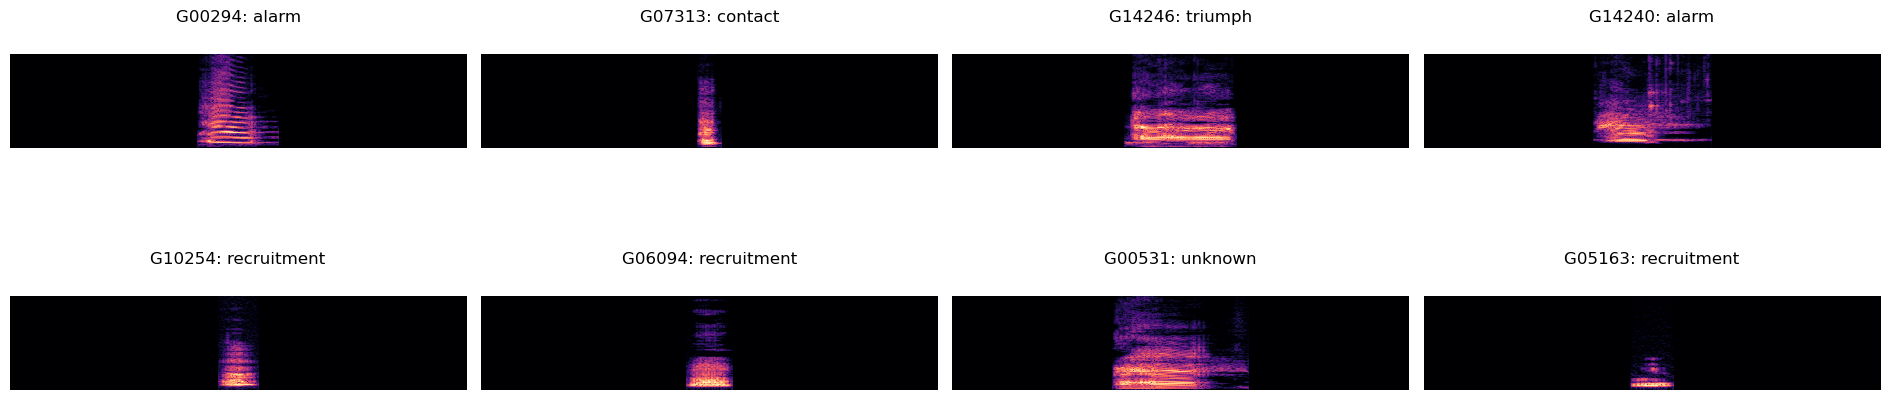

In [39]:
# plot random sample of 8 calls, linearly scaled and padded
sample_calls = calls_df.sample(n=8, random_state=42)

# plot first 8 calls
#sample_calls = calls_df.iloc[:8]

fig, axes = plt.subplots(2, 4, figsize=(19, 6))

for i, (_, vocalization) in enumerate(sample_calls.iterrows()):
  row = i // 4
  col = i % 4
  axes[row, col].matshow(vocalization["padded_spectrogram"], origin="lower", cmap="magma")
  axes[row, col].set_title(f'{vocalization["clip_ID"]}: {vocalization["call_type"]}', )
  axes[row, col].axis("off") 
    
for i in range(len(sample_calls), 8):
  row = i // 4
  col = i % 4
  axes[row, col].axis("off")

plt.tight_layout()
plt.show()

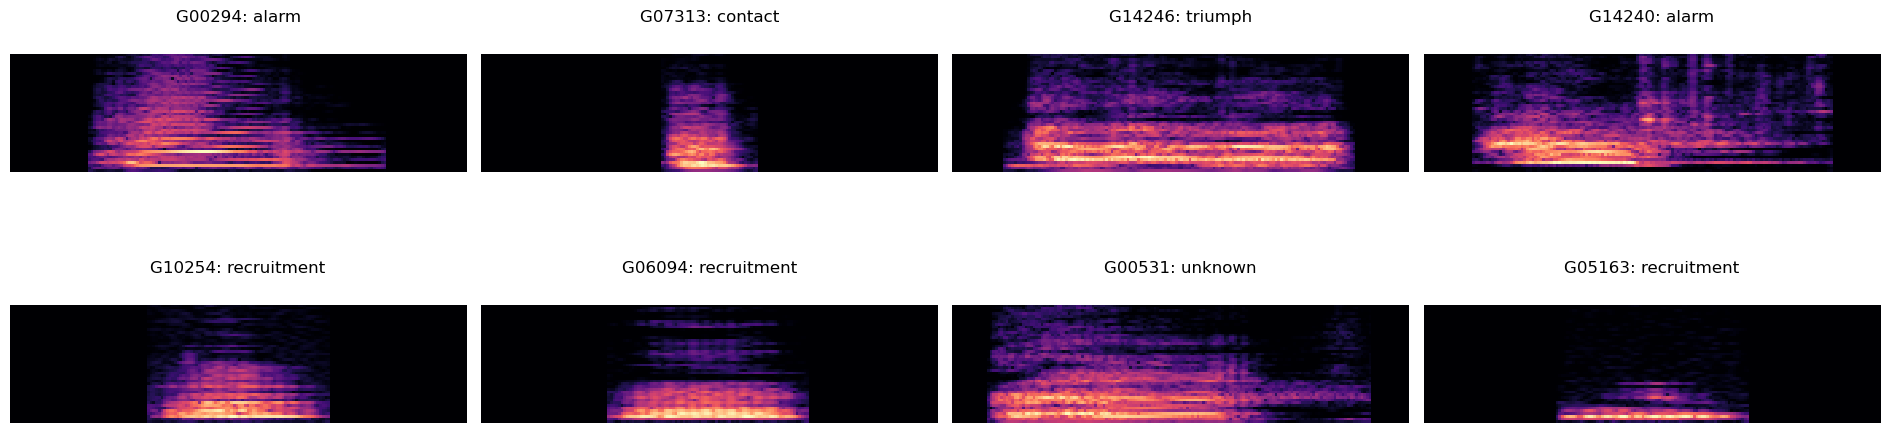

In [40]:
# plot random sample of 8 calls, log scaled and padded
sample_calls = calls_df.sample(n=8, random_state=42)

# plot first 8 calls
#sample_calls = calls_df.iloc[:8]

fig, axes = plt.subplots(2, 4, figsize=(19, 6))

for i, (_, vocalization) in enumerate(sample_calls.iterrows()):
  row = i // 4
  col = i % 4
  axes[row, col].matshow(vocalization["log_padded_spectrogram"], origin="lower", cmap="magma")
  axes[row, col].set_title(f'{vocalization["clip_ID"]}: {vocalization["call_type"]}', )
  axes[row, col].axis("off") 
    
for i in range(len(sample_calls), 8):
  row = i // 4
  col = i % 4
  axes[row, col].axis("off")

plt.tight_layout()
plt.show()

[Text(0.5, 1.0, 'GT00240 G01117: unknown')]

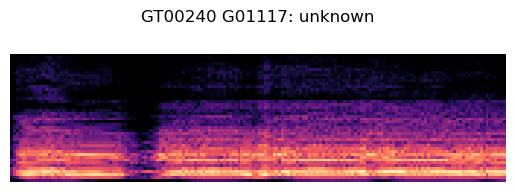

In [41]:
fig, ax = plt.subplots()
longest_call_total = calls_df.loc[calls_df["duration"].idxmax()]
ax.matshow(longest_call_total["log_padded_spectrogram"], origin="lower", cmap="magma")
ax.axis("off")
ax.set(title=f'{longest_call_total["track_ID"]} {longest_call_total["clip_ID"]}: {longest_call_total["call_type"]}')

[Text(0.5, 1.0, 'GT00210 G00905: distance')]

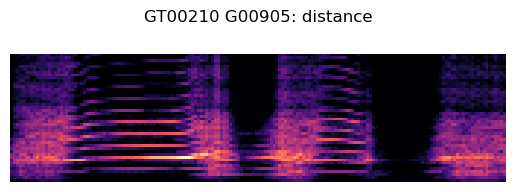

In [42]:
fig, ax = plt.subplots()
loudest_call_total = calls_df.loc[calls_df["peak"].idxmax()]
ax.matshow(loudest_call_total["log_padded_spectrogram"], origin="lower", cmap="magma")
ax.axis("off")
ax.set(title=f'{loudest_call_total["track_ID"]} {loudest_call_total["clip_ID"]}: {loudest_call_total["call_type"]}')

[Text(0.5, 1.0, 'GT00987 G12981: triumph')]

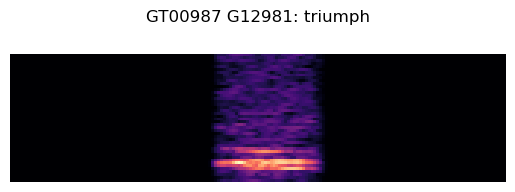

In [43]:
fig, ax = plt.subplots()
quietest_call_total = calls_df.loc[calls_df["peak"].idxmin()]
ax.matshow(quietest_call_total["log_padded_spectrogram"], origin="lower", cmap="magma")
ax.axis("off")
ax.set(title=f'{quietest_call_total["track_ID"]} {quietest_call_total["clip_ID"]}: {quietest_call_total["call_type"]}')

#### Extract audio features using **Praat/Parselmouth**: 


In [44]:
#TODO: ~800 NA returns - check why and fix or find better solution

**Temporal features (retrieved from temporal envelope in amlitude pressure):**
- Mean T: temporal centroid
- Std T: temporal duration
- Skew T: temporal skewness (asymmery)
- Kurt T: temporal kurtosis (peakedness)
- Ent T: temporal entropy (overall variability)

**Spectral features (from spectral envelope in power/pressure square):**
- Mean S: spectral centroid
- Std S: spectral duration
- Skew S: spectral skewness (asymmery)
- Kurt S: spectral kurtosis (peakedness)
- Ent S: spectral entropy (overall variability)
- Q1, Q2, G3: q-th quartile of power spectrum

**From time-varying fundamental frequency:**
- Mean F0: mean fundamental frequency
- Sal: mean pitch saliency (ratio)
- Max F0: mean fundamental
- Min F0: minimum fundamental
- CV F0: coefficient of variation (measure of frequency modulation)

In [45]:
BANDPASS_LOW, BANDPASS_HIGH = 60, 10000 # used in spectral analysis (see below)
F0_FLOOR = 350 # leads to window of ~0.002 seconds
F0_CEIL = 2000
VTL_M = 0.378 # Würdinger 1970, taken from Anser fabilis, because most similar overall body size to Anser anser

In [81]:
def _exclude_trailing_and_leading_zeros(envelope):
    # Exclude trailing zeros (identify the last non-zero element)
    non_zero_end = np.argmax(envelope[::-1] > 0)
    envelope = envelope[:len(envelope) - non_zero_end]
    # Exclude leading zeros (find the first non-zero value)
    non_zero_start = np.argmax(envelope > 0)
    envelope = envelope[non_zero_start:]
    return envelope

In [207]:
def _dominant_freqs(amp_spectrogram, freqs, history_size=3):    
    dominant_freqs = []
    amp_range = np.max(amp_spectrogram)-np.min(amp_spectrogram)

    # Iterate over time frames
    for t in range(amp_spectrogram.shape[1]):
        # Get power spectrum for time frame
        power_spectrum = amp_spectrogram[:, t]
        peaks, _ = signal.find_peaks(power_spectrum, height=amp_range*0.05, distance=len(freqs)//50, prominence=amp_range*0.05) # 5% of amp range, 5% of freq bins, 5% of amp range

        # If no peaks, take frequency with highest amplitude
        if len(peaks) == 0:
            dominant_freq = freqs[np.argmax(power_spectrum)]
        else:
            if len(dominant_freqs) >= history_size:
                recent_avg_freq = np.mean(dominant_freqs[-history_size:])
            else:
                recent_avg_freq = np.mean(dominant_freqs) if dominant_freqs else freqs[peaks[0]]  # Fallback to the first peak

            # Choose peak closest to the previous dominant frequency
            if len(dominant_freqs) == 0:
                # for first frame
                dominant_freq = freqs[peaks[np.argmax(power_spectrum[peaks])]]
            else:
                # For subsequent frames: find peak closest to recent average frequency
                distances = np.abs(freqs[peaks] - recent_avg_freq)
                closest_peak = peaks[np.argmin(distances)]
                dominant_freq = freqs[closest_peak]

        dominant_freqs.append(dominant_freq)
    return np.asarray(dominant_freqs)

In [223]:
class AudioFeatureAnalysis:
    def __init__(self, y, sr, filepath, f0_floor=300, f0_ceil=2000, bandpass_low=40, bandpass_high=17000):
        """
        Parameters:
            y: ndarray
                Audio signal.
            sr: int
                Sampling rate of the audio signal.
            filepath: str
                Path to the audio file (needed for Parselmouth).
            f0_floor: float
                Minimum fundamental frequency for F0 analysis.
            f0_ceil: float
                Maximum fundamental frequency for F0 analysis.
            bandpass_low: float
                Lower frequency bound for spectral analysis (Hz).
            bandpass_high: float
                Upper frequency bound for spectral analysis (Hz).
        """
        self.y = y
        self.sr = sr
        self.filepath = filepath
        self.f0_floor = f0_floor
        self.f0_ceil = f0_ceil
        self.bandpass_low = bandpass_low
        self.bandpass_high = bandpass_high
        self.features = {}
        self.calculate_time_features()
        self.calculate_spectral_features(welch=True)
        self.calculate_dominant_frequency_features()
        self.calculate_power_spectral_entropy()
        self.calculate_hnr()
        self.calculate_f0_features()
        self.features["spectrographic_entropy"] = self.features["pse"] * self.features["t_entropy"]

    def calculate_time_features(self):
        """
        Calculate time-domain features.
        """
        analytic_signal = signal.hilbert(self.y)
        amplitude_envelope = np.abs(analytic_signal)

        # Apply Daniell kernel (moving average kernel)
        kernel_size = 101  # must be odd
        kernel = np.ones(kernel_size) / kernel_size

        # Apply kernel to smooth envelope
        smoothed_envelope = signal.convolve(amplitude_envelope, kernel, mode='same')

        smoothed_envelope = _exclude_trailing_and_leading_zeros(smoothed_envelope)

        # Replace small values inside the envelope with a small constant (e.g., 1e-10) to avoid log conflicts
        small_value_threshold = 1e-10
        smoothed_envelope = np.where(smoothed_envelope < small_value_threshold, small_value_threshold, smoothed_envelope)

        normalized_env = smoothed_envelope / np.sum(smoothed_envelope)
        cumulative_ae = np.cumsum(normalized_env)

        t_q1 = np.searchsorted(cumulative_ae, 0.25) / self.sr
        t_median = np.searchsorted(cumulative_ae, 0.5) / self.sr
        t_q3 = np.searchsorted(cumulative_ae, 0.75) / self.sr

        std_t = np.std(smoothed_envelope)
        skew_t = skew(smoothed_envelope)
        kurt_t = kurtosis(smoothed_envelope)
        _, counts = np.unique(smoothed_envelope, return_counts=True)
        norm_counts = counts / counts.sum()
        t_entropy = -np.sum(norm_counts * np.log2(norm_counts))

        self.features.update({
            "amplitude_envelope": smoothed_envelope,
            "t_q1": t_q1,
            "t_median": t_median,
            "t_q3": t_q3,
            "std_t": std_t,
            "skew_t": skew_t,
            "kurt_t": kurt_t,
            "t_entropy": t_entropy
        })

    def calculate_spectral_features(self, welch=False):
        """
        Calculate spectral features.
        """
        amp_spectrum = np.abs(fft.fft(self.y))
        pow_spectrum = amp_spectrum**2
        freqs = np.fft.fftfreq(len(self.y), d=1/self.sr)

        if welch:
            freqs, pow_spectrum = signal.welch(self.y, self.sr, nperseg=len(self.y)//8)

        mask = (freqs >= self.bandpass_low) & (freqs <= self.bandpass_high)
        filtered_freqs = freqs[mask]
        filtered_ps = pow_spectrum[mask]

        weighted_stats = DescrStatsW(filtered_freqs, weights=filtered_ps, ddof=1)
        mean_f = weighted_stats.mean / 1000
        std_f = weighted_stats.std / 1000
        mean_peak_f = filtered_freqs[np.argmax(filtered_ps)] / 1000
        flatness_s = gmean(filtered_ps) / np.mean(filtered_ps)
        
        # Normalize the power spectrum and calculate cumulative sum
        normalized_ps = filtered_ps / np.sum(filtered_ps)
        cumulative_ps = np.cumsum(normalized_ps)

        f_q1 = filtered_freqs[np.searchsorted(cumulative_ps, 0.25)]
        f_median = filtered_freqs[np.searchsorted(cumulative_ps, 0.5)]
        f_q3 = filtered_freqs[np.searchsorted(cumulative_ps, 0.75)]

        self.features.update({
            "freqs_ps": filtered_freqs,
            "filtered_pow_spectrum": filtered_ps,
            "mean_f": mean_f,
            "std_f": std_f,
            "mean_peak_f": mean_peak_f,
            "flatness_s": flatness_s,
            "f_q1": f_q1,
            "f_median": f_median,
            "f_q3": f_q3,
        })

    def calculate_dominant_frequency_features(self):
        """
        Calculate dominant frequency features.
        """
        spectrogram = librosa.stft(self.y, n_fft=N_FFT, hop_length=N_FFT//HOP_OVERLAP)
        amp_spectrogram = np.abs(spectrogram)
        freqs = librosa.fft_frequencies(sr=self.sr, n_fft=N_FFT)

        dominant_freqs = _dominant_freqs(amp_spectrogram, freqs)
        # Apply Daniell kernel (moving average kernel)
        kernel_size = 21  # must be odd
        kernel = np.ones(kernel_size) / kernel_size

        # Apply kernel to smooth envelope
        dominant_freqs = signal.convolve(dominant_freqs, kernel, mode='same')

        min_dom, max_dom = np.min(dominant_freqs), np.max(dominant_freqs)
        range_dom = max_dom - min_dom
        cumulative_diff = np.sum(np.abs(np.diff(dominant_freqs)))
        mod_dom = cumulative_diff / range_dom if range_dom > 0 else 0

        self.features.update({
            "dominant_freqs": dominant_freqs,
            "mean_dom": np.mean(dominant_freqs),
            "min_dom": min_dom,
            "max_dom": max_dom,
            "range_dom": range_dom,
            "mod_dom": mod_dom
        })

    def calculate_power_spectral_entropy(self):
        """
        Calculates the power spectral entropy as follows:
        1. Calculate Power Spectral Distribution
        2. Normalize PSD (to treat it as a measure of probability)
        3. Calculate Shannon-Wiener entropy of normalized PSD using scipy

        https://de.mathworks.com/help/signal/ref/spectralentropy.html accessed January 13th, 2025. 18:34 pm
        """
        #_, psd = signal.welch(self.y, self.sr, nperseg=N_FFT, noverlap=N_FFT//HOP_OVERLAP) # would return psd - frequency spectrum squared and scaled by sum - 
        psd = np.abs(fft.fft(self.y, n=N_FFT)) ** 2
        psd_norm = psd / np.sum(psd)

        # TODO should I do this?
        psd_norm = _exclude_trailing_and_leading_zeros(psd_norm)
        # Ensure no zero values in normalized power distribution
        #psd_norm_nonzero = psd_norm[psd_norm > 0]
        psd_norm = np.where(psd_norm > 0, psd_norm, 1e-10)

        pse = -np.sum(psd_norm * np.log2(psd_norm))

        self.features["pse"] = pse
    
    def calculate_hnr(self):
        snd = parselmouth.Sound(self.filepath)
        harmonicity = snd.to_harmonicity()
        self.features.update({
            "hnr": harmonicity.values[harmonicity.values != -200].mean(),
            })

    def calculate_f0_features(self):
        """
        Calculate F0-related features using Parselmouth.
        """
        snd = parselmouth.Sound(self.filepath)
        pitch = parselmouth.praat.call(snd, "To Pitch", 0, self.f0_floor, self.f0_ceil)
        f0mean = parselmouth.praat.call(pitch, "Get mean", 0, 0, "Hertz") / 1000
        f0min = parselmouth.praat.call(pitch, "Get minimum", 0, 0, "Hertz", "parabolic") / 1000
        f0max = parselmouth.praat.call(pitch, "Get maximum", 0, 0, "Hertz", "parabolic") / 1000
        f0range = f0max - f0min

        self.features.update({
            "f0": pitch,
            "f0mean": f0mean,
            "f0min": f0min,
            "f0max": f0max,
            "f0range": f0range
        })

    def plot_features(self, plot_f0=True):
        """
        Create plots for the spectrogram, power spectrum, and waveform.
        """
        spectrogram = librosa.stft(self.y, n_fft=N_FFT, hop_length=N_FFT//HOP_OVERLAP)
        spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)
        times = librosa.times_like(self.features["dominant_freqs"], sr=self.sr, hop_length=N_FFT//HOP_OVERLAP)

        # Spectrogram with Dominant Frequencies
        plt.figure(figsize=(12, 12))
        plt.subplot(3, 1, 1)
        plt.title("Spectrogram with Dominant Frequencies")
        librosa.display.specshow(spectrogram_db, sr=self.sr, hop_length=(N_FFT // HOP_OVERLAP),
                                x_axis="time", y_axis="hz", cmap="viridis")
        plt.plot(times, self.features["dominant_freqs"], color='red', label='Dominant Frequency', alpha=0.6)
        plt.colorbar(format='%+2.0f dB')
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")
        plt.legend()

        # Power Spectrum and Spectral Features
        plt.subplot(3, 1, 2)
        plt.title("Power Spectrum with Spectral Features")
        plt.plot(self.features["freqs_ps"], self.features["filtered_pow_spectrum"], label="Power Spectrum", color='blue')
        plt.axvline(self.features["mean_f"] * 1000, color='green', linestyle="--", label="Mean Frequency (kHz)")
        plt.axvline(self.features["mean_peak_f"] * 1000, color='orange', linestyle="--", label="Peak Frequency (kHz)")
        plt.axvline(self.features["f_median"], color='red', linestyle="--", label="Median")
        plt.axvline(self.features["f_q1"], color='yellow', linestyle="--", label="Q1")
        plt.axvline(self.features["f_q3"], color='purple', linestyle="--", label="Q3")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Power")
        plt.legend()

        # Waveform with Envelope and Time-domain Features
        plt.subplot(3, 1, 3)
        plt.title("Waveform with Energy Envelope and Time-domain Features")
        times_waveform = np.linspace(0, len(self.y) / self.sr, num=len(self.y))
        plt.plot(times_waveform, self.y, label="Waveform", color="gray", alpha=0.3)
        plt.plot(times_waveform, self.features["amplitude_envelope"], label="Ampliutde Envelope", color="blue")
        plt.axvline(self.features["t_median"], color='red', linestyle="--", label="Median")
        plt.axvline(self.features["t_q1"], color='orange', linestyle="--", label="Q1")
        plt.axvline(self.features["t_q3"], color='green', linestyle="--", label="Q3")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()

        plt.tight_layout()
        plt.show()

In [48]:
def _plot_features(y, sr, filepath, plot_f0=True):
    """
    Generates three plots:
    1. Spectrogram with dominant frequency features.
    2. Power spectrum with spectral features.
    3. Waveform with energy envelope and time-domain features.
    
    Parameters:
        y: ndarray
            Audio signal.
        sr: int
            Sampling rate of the audio signal.
        filepath: str
            Path to the audio file (needed for Parselmouth).
        plot_f0: bool
            Whether to include pitch (F0) features in the analysis.
    """
    # Calculate features
    t_q1, t_median, t_q3, std_t, skew_t, kurt_t, t_entropy = _time_related_features(y)
    mean_f, std_f, mean_peak_f, flatness_s = _spectral_features(y, sr, BANDPASS_LOW, BANDPASS_HIGH)
    pse = _power_spectral_entropy(y, sr)
    dominant_freqs, mean_dom, min_dom, max_dom, range_dom, mod_dom = _dominant_frequency_related(y, sr)
    
    snd = parselmouth.Sound(filepath)
    if plot_f0:
        f0mean, f0min, f0max, f0range, f0std_dev, mean_slope, pitch, f0_q1, f0_q2, f0_q3 = _f0_related_features(snd, F0_FLOOR, F0_CEIL)
    
    # Prepare spectrogram and power spectrum
    spectrogram = librosa.stft(y, n_fft=N_FFT, hop_length=(N_FFT // HOP_OVERLAP))
    spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)
    times = librosa.times_like(dominant_freqs, sr=sr, hop_length=(N_FFT // HOP_OVERLAP))
    freqs = librosa.fft_frequencies(sr=sr, n_fft=N_FFT)
    
    # Power spectrum
    amp_spectrum = np.abs(np.fft.fft(y))
    pow_spectrum = amp_spectrum**2
    freqs_ps = np.fft.fftfreq(len(y), d=1/sr)
    mask = (freqs_ps >= BANDPASS_LOW) & (freqs_ps <= BANDPASS_HIGH)
    filtered_freqs_ps = freqs_ps[mask]
    filtered_pow_spectrum = pow_spectrum[mask]

    # Calculate energy envelope
    analytic_signal = signal.hilbert(y)
    energy_envelope = np.abs(analytic_signal)
    
    # Plot 1: Spectrogram with Dominant Frequencies
    plt.figure(figsize=(12, 6))
    plt.subplot(3, 1, 1)
    plt.title("Spectrogram with Dominant Frequencies")
    librosa.display.specshow(spectrogram_db, sr=sr, hop_length=(N_FFT // HOP_OVERLAP),
                             x_axis="time", y_axis="hz", cmap="viridis")
    plt.plot(times, dominant_freqs, color='red', label='Dominant Frequency')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.legend()

    # Plot 2: Power Spectrum and Spectral Features
    plt.subplot(3, 1, 2)
    plt.title("Power Spectrum with Spectral Features")
    plt.plot(filtered_freqs_ps, filtered_pow_spectrum, label="Power Spectrum", color='blue')
    plt.axvline(mean_f * 1000, color='green', linestyle="--", label="Mean Frequency (kHz)")
    plt.axvline(mean_peak_f * 1000, color='orange', linestyle="--", label="Peak Frequency (kHz)")
    plt.axhline(flatness_s * np.max(filtered_pow_spectrum), color='purple', linestyle="--", label="Flatness")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.legend()

    # Plot 3: Waveform with Envelope and Time-domain Features
    plt.subplot(3, 1, 3)
    plt.title("Waveform with Energy Envelope and Time-domain Features")
    times_waveform = np.linspace(0, len(y) / sr, num=len(y))
    plt.plot(times_waveform, y, label="Waveform", color="gray", alpha=0.6)
    plt.plot(times_waveform, energy_envelope, label="Energy Envelope", color="blue")
    plt.axhline(t_median, color='red', linestyle="--", label="Median Energy")
    plt.axhline(t_q1, color='orange', linestyle="--", label="Q1 Energy")
    plt.axhline(t_q3, color='green', linestyle="--", label="Q3 Energy")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [49]:
# def calc_features(y, sr, filepath, f0=True, plot=True):
#     """
#     TODO docs
#     # """
#     t_q1, t_median, t_q3, std_t, skew_t, kurt_t, t_entropy = _time_related_features(y)
#     mean_f, std_f, mean_peak_f, flatness_s = _spectral_features(y, sr, BANDPASS_LOW, BANDPASS_HIGH)
#     pse = _power_spectral_entropy(y, sr)
#     spectrographic_entropy = pse * t_entropy # https://rdrr.io/cran/warbleR/man/spectro_analysis.html accessed January 13th, 2025. 19:36 pm
#     snd = parselmouth.Sound(filepath)
#     centr_s, skew_s, kurt_s, std_s, s_q1, s_median, s_q3, iqr_f = _spectral_features_psm(snd)
#     dominant_freqs, mean_dom, min_dom, max_dom, range_dom, mod_dom = _dominant_frequency_related(y, sr)
#     if f0:
#         f0mean, f0min, f0max, f0range, f0std_dev, mean_slope, pitch, f0_q1, f0_q2, f0_q3 = _f0_related_features(snd, F0_FLOOR, F0_CEIL)
#     if plot:
#         _plot_features(y, sr, filepath, f0)

In [50]:
# ### old feature calculation
# def calculate_f0_related_features(snd, f0_floor, f0_ceil):
#     # https://parselmouth.readthedocs.io/en/stable/api_reference.html#parselmouth.Sound.to_pitch
#     pitch = parselmouth.praat.call(snd, "To Pitch", 0, f0_floor, f0_ceil)
#     f0mean = parselmouth.praat.call(pitch, "Get mean", 0, 0, "Hertz")/1000 # to kHz
#     f0min = parselmouth.praat.call(pitch, "Get minimum", 0, 0, "Hertz", "parabolic")/1000 # to kHz
#     f0max = parselmouth.praat.call(pitch, "Get maximum", 0, 0, "Hertz", "parabolic")/1000 # to kHz
#     f0range = (f0max - f0min) / 1000 # to kHz
#     f0std_dev = parselmouth.praat.call(pitch, "Get standard deviation", 0, 0, "Hertz")/1000 # to kHz
#     mean_slope = pitch.get_mean_absolute_slope()/1000 # to kHz/s
#     f0_q1 = parselmouth.praat.call(pitch, "Get quantile", 0.0, 0.0, 0.25, "Hertz")/1000 # to kHz
#     f0_q2 = parselmouth.praat.call(pitch, "Get quantile", 0.0, 0.0, 0.5, "Hertz")/1000 # to kHz
#     f0_q3 = parselmouth.praat.call(pitch, "Get quantile", 0.0, 0.0, 0.75, "Hertz")/1000 # to kHz
#     return f0mean, f0min, f0max, f0range, f0std_dev, mean_slope, pitch, f0_q1, f0_q2, f0_q3

# # spectral
# def calculate_hnr(snd):
#     harmonicity = snd.to_harmonicity()
#     return harmonicity.values[harmonicity.values != -200].mean()

# def calculate_spectral_features(snd):
#     spectrum = snd.to_spectrum()
#     centr_s = spectrum.get_center_of_gravity()/1000 # to kHz
#     skew_s = spectrum.get_skewness()
#     kurt_s = spectrum.get_kurtosis()
#     std_s = spectrum.get_standard_deviation()/1000 # to kHz
#     return centr_s, skew_s, kurt_s, std_s
# """
# - -- Mean S: spectral centroid
# - -- Std S: spectral std
# - -- Skew S: spectral skewness (asymmery)
# - -- Kurt S: spectral kurtosis (peakedness)
# - Ent S: spectral entropy (overall variability)
# - -- Q1, Q2, Q3: q-th quartile of power spectrum
# """

# # temporal
# def calculate_temporal_features(snd):
#     intensity = snd.to_intensity(minimum_pitch=350)
#     centr_t = intensity.centre_time
#     std_t = np.std(intensity.values[0])
#     skew_t = skew(intensity.values[0])
#     kurt_t = kurtosis(intensity.values[0])
#     return centr_t, skew_t, kurt_t, std_t, intensity

# """
# - Cent T: temporal centroid
# - Std T: temporal std
# - Skew T: temporal skewness (asymmery)
# - Kurt T: temporal kurtosis (peakedness)
# """

# # formants
# def _estimate_formant_ceiling(vtl_m):
#     return 15*(340/(4*vtl_m))*1.1 # lower formants are expected to be below f0

# def calculate_first_formant(snd):
#     # adapted from https://github.com/drfeinberg/PraatScripts/blob/master/Measure%20Pitch%2C%20HNR%2C%20Jitter%2C%20Shimmer%2C%20and%20Formants.ipynb
#     formant_ceiling = _estimate_formant_ceiling(VTL_M)
#     pointProcess = parselmouth.praat.call(snd, "To PointProcess (periodic, cc)", F0_FLOOR, F0_CEIL)
#     formant = parselmouth.praat.call(snd, "To Formant (burg)", 0.0, 1, formant_ceiling, 0.001, 100)
#     numPoints = parselmouth.praat.call(pointProcess, "Get number of points")

#     f1_list = []
#     # Measure formant only at glottal pulses
#     for point in range(0, numPoints):
#         point += 1
#         t = parselmouth.praat.call(pointProcess, "Get time from index", point)
#         f1 = parselmouth.praat.call(formant, "Get value at time", 1, t, 'Hertz', 'Linear')
#         f1_list.append(f1)
    
#     f1_list = [f1 for f1 in f1_list if str(f1) != 'nan']
    
#     # calculate mean formant across pulses
#     f1_mean = np.mean(f1_list)/1000 # to kHz
#     return f1_mean, f1_list

In [57]:
# def plot_feature_analysis(snd, f0_floor, f0_ceil, vtl_m):
#     # Calculate the features
#     f0mean, f0min, f0max, f0range, f0std_dev, mean_slope, pitch, f0_q1, f0_q2, f0_q3 = calculate_f0_related_features(snd, f0_floor, f0_ceil)
#     hnr = calculate_hnr(snd)
#     centr_s, skew_s, kurt_s, std_s = calculate_spectral_features(snd)
#     centr_t, skew_t, kurt_t, std_t, intensity = calculate_temporal_features(snd)
#     f1_mean, f1_list = calculate_first_formant(snd)

#     # Time vector for the features
#     times = np.linspace(0, len(snd.values[0])/snd.xmax, len(snd.values[0]))

#     # Create figure and subplots
#     plt.figure(figsize=(15, 12))

#     # Plot F0-related features
#     plt.subplot(4, 1, 1)
#     plt.title("F0-Related Features")
#     plt.plot(times, f0mean * np.ones_like(times), label="Mean F0 (kHz)", color='blue')
#     plt.plot(times, f0min * np.ones_like(times), label="Min F0 (kHz)", color='red')
#     plt.plot(times, f0max * np.ones_like(times), label="Max F0 (kHz)", color='green')
#     plt.plot(times, f0range * np.ones_like(times), label="F0 Range (kHz)", color='purple')
#     plt.plot(times, f0std_dev * np.ones_like(times), label="F0 Std Dev (kHz)", color='orange')
#     plt.plot(times, mean_slope * np.ones_like(times), label="F0 Mean Slope (kHz/s)", color='brown')
#     plt.legend()
#     plt.xlabel("Time (s)")
#     plt.ylabel("Frequency (kHz)")

#     # Plot Spectral features
#     plt.subplot(4, 1, 2)
#     plt.title("Spectral Features")
#     plt.plot(times, centr_s * np.ones_like(times), label="Spectral Centroid (kHz)", color='blue')
#     plt.plot(times, skew_s * np.ones_like(times), label="Spectral Skewness", color='red')
#     plt.plot(times, kurt_s * np.ones_like(times), label="Spectral Kurtosis", color='green')
#     plt.plot(times, std_s * np.ones_like(times), label="Spectral Std Dev (kHz)", color='purple')
#     plt.legend()
#     plt.xlabel("Time (s)")
#     plt.ylabel("Value")

#     # Plot Temporal features
#     plt.subplot(4, 1, 3)
#     plt.title("Temporal Features")
#     plt.plot(times, centr_t * np.ones_like(times), label="Temporal Centroid", color='blue')
#     plt.plot(times, skew_t * np.ones_like(times), label="Temporal Skewness", color='red')
#     plt.plot(times, kurt_t * np.ones_like(times), label="Temporal Kurtosis", color='green')
#     plt.plot(times, std_t * np.ones_like(times), label="Temporal Std Dev", color='purple')
#     plt.legend()
#     plt.xlabel("Time (s)")
#     plt.ylabel("Value")

#     # Plot Formants (F1 Mean and F1 List)
#     plt.subplot(4, 1, 4)
#     plt.title("Formants (F1)")
#     plt.plot(times, f1_mean * np.ones_like(times), label="Mean F1 (kHz)", color='blue')
#     plt.scatter(times[:len(f1_list)], f1_list, label="F1 Values (kHz)", color='red', alpha=0.6)
#     plt.legend()
#     plt.xlabel("Time (s)")
#     plt.ylabel("Frequency (kHz)")

#     # Show all plots
#     plt.tight_layout()
#     plt.show()


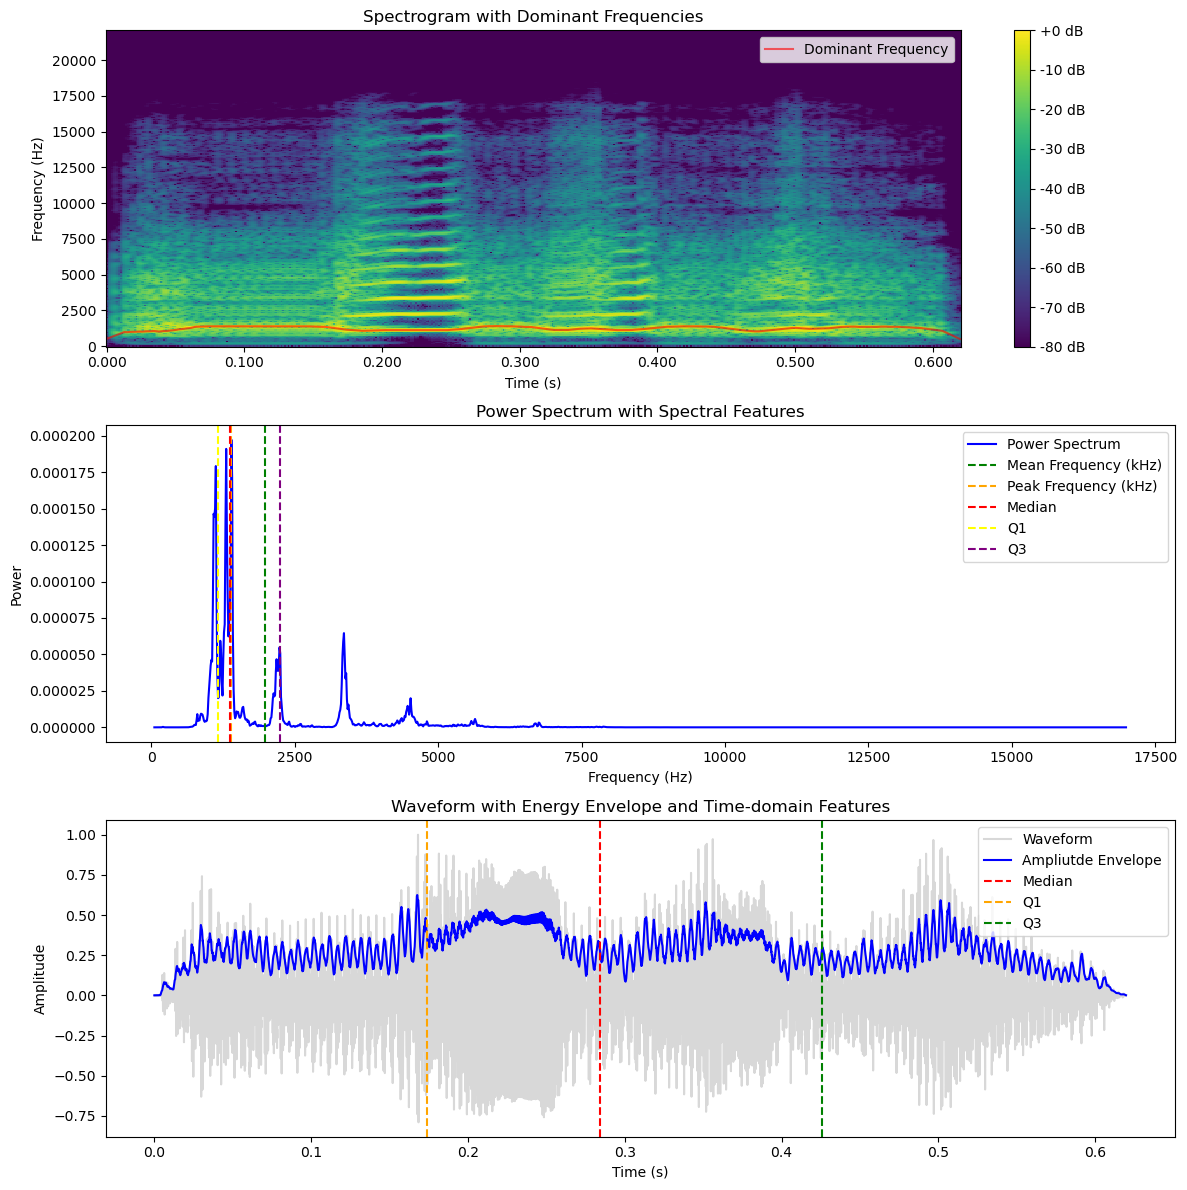

In [225]:
i= 1000
analysis = AudioFeatureAnalysis(calls_df.iloc[i]["waveform"], calls_df.iloc[i]["sr"], filepath=calls_df.iloc[i]["filepath"])

analysis.calculate_f0_features()
analysis.plot_features()

In [53]:
# fundamental
# TODO check documentation/comments
"""
- ~~ Mean F0: mean fundamental frequency
- ~~ Sal: mean pitch saliency (ratio) - hnr instead
- ~~ Max F0: maximum fundamental
- ~~ Min F0: minimum fundamental
- ~~ CV F0: coefficient of variation (measure of frequency modulation) -std instead
- -- Q1, Q2, Q3: q-th quartile of f_0
"""
def calculate_f0_related_features(snd, f0_floor, f0_ceil):
    # https://parselmouth.readthedocs.io/en/stable/api_reference.html#parselmouth.Sound.to_pitch
    pitch = parselmouth.praat.call(snd, "To Pitch", 0, f0_floor, f0_ceil)
    f0mean = parselmouth.praat.call(pitch, "Get mean", 0, 0, "Hertz")/1000 # to kHz
    f0min = parselmouth.praat.call(pitch, "Get minimum", 0, 0, "Hertz", "parabolic")/1000 # to kHz
    f0max = parselmouth.praat.call(pitch, "Get maximum", 0, 0, "Hertz", "parabolic")/1000 # to kHz
    f0range = (f0max - f0min) / 1000 # to kHz
    f0std_dev = parselmouth.praat.call(pitch, "Get standard deviation", 0, 0, "Hertz")/1000 # to kHz
    mean_slope = pitch.get_mean_absolute_slope()/1000 # to kHz/s
    f0_q1 = parselmouth.praat.call(pitch, "Get quantile", 0.0, 0.0, 0.25, "Hertz")/1000 # to kHz
    f0_q2 = parselmouth.praat.call(pitch, "Get quantile", 0.0, 0.0, 0.5, "Hertz")/1000 # to kHz
    f0_q3 = parselmouth.praat.call(pitch, "Get quantile", 0.0, 0.0, 0.75, "Hertz")/1000 # to kHz
    return f0mean, f0min, f0max, f0range, f0std_dev, mean_slope, pitch, f0_q1, f0_q2, f0_q3

# spectral
def calculate_hnr(snd):
    harmonicity = snd.to_harmonicity()
    return harmonicity.values[harmonicity.values != -200].mean()

"""
- -- Mean S: spectral centroid
- -- Std S: spectral std
- -- Skew S: spectral skewness (asymmery)
- -- Kurt S: spectral kurtosis (peakedness)
- Ent S: spectral entropy (overall variability)
- -- Q1, Q2, Q3: q-th quartile of power spectrum
"""
def calculate_spectral_features(snd):
    spectrum = snd.to_spectrum()
    centr_s = spectrum.get_center_of_gravity()/1000 # to kHz
    skew_s = spectrum.get_skewness()  ###
    kurt_s = spectrum.get_kurtosis()  ###
    std_s = spectrum.get_standard_deviation()/1000 # to kHz
    s_q1 = np.quantile(spectrum, 0.25)
    s_median = np.quantile(spectrum, 0.5)
    s_q3 = np.quantile(spectrum, 0.75)
    dominant_freq = _calculate_dominant_frequency(snd, sr)/1000 # to kHz
    return centr_s, skew_s, kurt_s, std_s, s_q1, s_median, s_q3, dominant_freq

"""
- Cent T: temporal centroid
- Std T: temporal std
- Skew T: temporal skewness (asymmery)
- Kurt T: temporal kurtosis (peakedness)
"""
# temporal
def calculate_temporal_features(snd):
    intensity = snd.to_intensity(minimum_pitch=350)
    centr_t = intensity.centre_time
    std_t = np.std(intensity.values[0])
    skew_t = skew(intensity.values[0])
    kurt_t = kurtosis(intensity.values[0])
    return centr_t, skew_t, kurt_t, std_t, intensity

# formants
def _estimate_formant_ceiling(vtl_m):
    return 15*(340/(4*vtl_m))*1.1 # lower formants are expected to be below f0

def calculate_first_formant(snd):
    # adapted from https://github.com/drfeinberg/PraatScripts/blob/master/Measure%20Pitch%2C%20HNR%2C%20Jitter%2C%20Shimmer%2C%20and%20Formants.ipynb
    formant_ceiling = _estimate_formant_ceiling(VTL_M)
    pointProcess = parselmouth.praat.call(snd, "To PointProcess (periodic, cc)", F0_FLOOR, F0_CEIL)
    formant = parselmouth.praat.call(snd, "To Formant (burg)", 0.0, 1, formant_ceiling, 0.001, 100)
    numPoints = parselmouth.praat.call(pointProcess, "Get number of points")

    f1_list = []
    # Measure formant only at glottal pulses
    for point in range(0, numPoints):
        point += 1
        t = parselmouth.praat.call(pointProcess, "Get time from index", point)
        f1 = parselmouth.praat.call(formant, "Get value at time", 1, t, 'Hertz', 'Linear')
        f1_list.append(f1)
    
    f1_list = [f1 for f1 in f1_list if str(f1) != 'nan']
    
    # calculate mean formant across pulses
    f1_mean = np.mean(f1_list)/1000 # to kHz
    return f1_mean, f1_list


In [54]:
def calc_features(filepath, plot_spectrogram=False):
    snd = parselmouth.Sound(filepath)
    # TODO extract dominant frequency as well or even instead of fundamental
    # TODO add featured derived from spectrum (get dom f on the way?)
    f0mean, f0min, f0max, f0range, f0std_dev, mean_slope, pitch, f0_q1, f0_q2, f0_q3 = calculate_f0_related_features(snd, F0_FLOOR, F0_CEIL)
    hnr = calculate_hnr(snd)
    # spectral
    centr_s, skew_s, kurt_s, std_s, s_q1, s_q2, s_q3, dominant_freq = calculate_spectral_features(snd)
    # temporal
    centr_t, skew_t, kurt_t, std_t, intensity = calculate_temporal_features(snd)
    # formants
    formant, formant_list = calculate_first_formant(snd)
    if plot_spectrogram:
        plot_feature_spectrogram(snd, pitch, intensity, formant_list)
    return pd.DataFrame([[
        filepath, f0mean, f0range, f0min, f0max, f0std_dev, mean_slope, f0_q1, f0_q2, f0_q3, hnr, centr_s, skew_s, kurt_s, std_s, s_q1, s_q2, s_q3, dominant_freq, centr_t, skew_t, kurt_t, std_t, formant]], 
        columns = [
            "filepath", "f0mean", "f0range", "f0min", "f0max", "f0std_dev", "mean_slope", "f0_q1", "f0_q2", "f0_q3", "hnr", "centr_s", "skew_s", "kurt_s", "std_s", "spectrum_q1", "spectrum_q2", "spectrum_q3", "dominant_freq", "centr_t", "skew_t", "kurt_t", "std_t", "avg_f_form1"
            ])

In [55]:
features_df = calc_features(calls_df.iloc[1220]["filepath"], plot_spectrogram=True)
features_df.head()

NameError: name '_calculate_dominant_frequency' is not defined

In [44]:
features_df = pd.DataFrame()

for _, row in calls_df.iterrows():
    temp_df = calc_features(row["filepath"])
    features_df = pd.concat([features_df, temp_df], ignore_index=True)

features_df.head()

/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [174]:
calls_df = pd.merge(calls_df, features_df, how='left', on='filepath')

In [ ]:
calls_df.head()

,track_ID,clip_ID,goose_ID,call_type,waveform,sr,filepath,spectrogram,lfccs,peak,...,std_s,spectrum_q1,spectrum_q2,spectrum_q3,dominant_freq,centr_t,skew_t,kurt_t,std_t,avg_f_form1
0,GT00780,G11666,Lando,recruitment,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.019933237, 0.060814682, 0.073473...","[[-384.75204, -391.9265, -395.2193, -387.9781,...",0.009796,...,0.172809,-1.209596e-08,-6.038695e-11,1.214423e-08,32857.687254,0.060397,-1.169735,0.208856,10.638023,0.929733
1,GT00772,G11510,Burglar,recruitment,"[-0.00084985833, 0.00084985833, 0.0028328612, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.032295033, 0.025360242, 0.0, 0.0, 0.0, 0.0...","[[-335.15942, -320.47253, -313.74426, -309.589...",0.107727,...,0.744212,-1.038952e-07,-2.433803e-10,1.140187e-07,49648.121260,0.056848,-0.869065,-0.289031,10.923155,1.525552
2,GT00795,G11994,EinStein,contact,"[0.004903678, 0.0052539404, 0.0038528896, 0.00...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.028061852, 0.015824763, 0.017440086, 0.045...","[[-391.72293, -381.86548, -371.19098, -360.817...",0.087128,...,0.645904,-1.101117e-07,-2.041412e-09,9.836067e-08,58662.052786,0.054127,-1.244654,0.553326,9.605882,1.472652
3,GT00447,G04128,BruceSpringsteen,departure,"[0.00017799929, -0.00035599858, -0.001245995, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0150192985, 0.0094179325, 0.00040014132, 0...","[[-349.48306, -330.95694, -313.1729, -300.9760...",0.171448,...,1.358531,-1.335888e-06,-7.228877e-11,1.354840e-06,49154.808543,0.089717,-1.362490,1.175284,11.304043,2.492349
4,GT00775,G11567,Anthony,recruitment,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00143884...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0033818383, 0.075...","[[-391.88184, -385.90564, -381.499, -375.24374...",0.021210,...,0.278164,-1.443861e-08,2.357518e-10,1.458853e-08,34618.359822,0.053503,-1.264512,0.456110,10.050527,1.032702


In [176]:
len(calls_df[calls_df["avg_f_form1"].isna()])

811

In [ ]:
calls_df[calls_df.isna().any(axis=1)]

,track_ID,clip_ID,goose_ID,call_type,waveform,sr,filepath,spectrogram,lfccs,peak,...,std_s,spectrum_q1,spectrum_q2,spectrum_q3,dominant_freq,centr_t,skew_t,kurt_t,std_t,avg_f_form1
9,GT00157,G00695,Lukka,departure,"[-0.0064276885, -0.0014833127, 0.0012360939, 0...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.21430194, 0.21162803, 0.16451198, 0.118193...","[[-385.6243, -384.9623, -385.97726, -379.05316...",0.123444,...,1.155042,-1.163558e-06,2.828482e-10,1.178635e-06,59806.115007,0.218265,-3.990843,15.904626,69.956004,NaN
14,GT00570,G06457,Batate,contact,"[-0.016129032, -0.014976959, -0.014976959, -0....",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.09936429, 0.0, 0.036845606, 0.09943843, 0....","[[-396.35135, -386.8086, -377.8576, -372.8289,...",0.026489,...,0.259464,-1.212544e-08,-1.030100e-10,1.204124e-08,32633.146176,0.035136,-1.128598,0.375292,7.638876,NaN
20,GT00997,G14404,Jurek,triumph,"[-0.012969468, -0.014050256, -0.012158876, -0....",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.28321043, 0.2838215, 0.2625425, 0.3906251,...","[[-163.63493, -133.54736, -118.72049, -115.746...",0.112946,...,1.242590,-4.013049e-07,7.494922e-09,3.839508e-07,128867.877869,0.026179,-1.208455,0.438088,4.529283,NaN
55,GT00735,G10541,Babaco,contact,"[0.000996016, 0.000498008, 0.0, 0.0, 0.0, 0.0,...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.11823099, 0.1262689, 0.11236494, 0.0862254...","[[-401.50958, -393.5983, -388.76654, -384.3465...",0.061279,...,0.957440,-2.245534e-08,1.231204e-10,2.268549e-08,26768.452247,0.040363,-0.690369,-0.869540,10.300219,NaN
58,GT00712,G09903,Natalie,recruitment,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.099603236, 0.07235824, 0.0, 0.08335743, 0....","[[-370.35394, -351.51218, -334.71136, -324.400...",0.017609,...,0.604050,-1.270755e-08,-6.398011e-11,1.277118e-08,30307.618525,0.051655,-1.176469,0.559713,14.751850,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7244,GT00599,G07283,Jurek,contact,"[-0.0047566774, -0.0045737284, -0.0036589827, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.02578072, 0.0016975848, 0.01490514, 0.0, 0...","[[-351.1967, -334.37296, -326.18976, -320.9608...",0.166809,...,0.671719,-8.882611e-08,4.253443e-10,8.947450e-08,39174.210526,0.034898,-1.183039,0.973352,7.929436,NaN
7260,GT00567,G06382,Leia,recruitment,"[0.003187251, 0.0023904382, 0.0023904382, 0.00...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.019273266, 0.051607553, 0.038061...","[[-425.3649, -420.10422, -419.91156, -422.8991...",0.038300,...,0.242497,-2.017995e-08,5.282440e-10,2.028281e-08,54626.007022,0.071043,-1.738945,2.068999,9.889794,NaN
7261,GT00712,G09959,Natalie,recruitment,"[0.0013063357, 0.00065316784, 0.00065316784, 0...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.09016874, 0.08055452, 0.02289738, 0.046543...","[[-427.6043, -422.89948, -419.73767, -403.9029...",0.046722,...,0.925793,-2.618122e-08,0.000000e+00,2.570096e-08,58832.722603,0.059592,-1.242429,0.233788,13.539251,NaN
7263,GT00991,G14289,unknown,distance,"[-0.04993097, -0.026461113, -0.0046019326, 0.0...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.38704023, 0.38882002, 0.36224985, 0.325290...","[[-268.5093, -267.89658, -265.49835, -261.6693...",0.132629,...,1.343792,-1.030102e-06,-1.595178e-08,1.075699e-06,62823.226501,0.089501,-2.198182,4.181746,4.321137,NaN


#### Display examples and export csv

/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_25672/465243084.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  example_calls = calls_df.groupby('call_type', group_keys=False).apply(subsample_group)


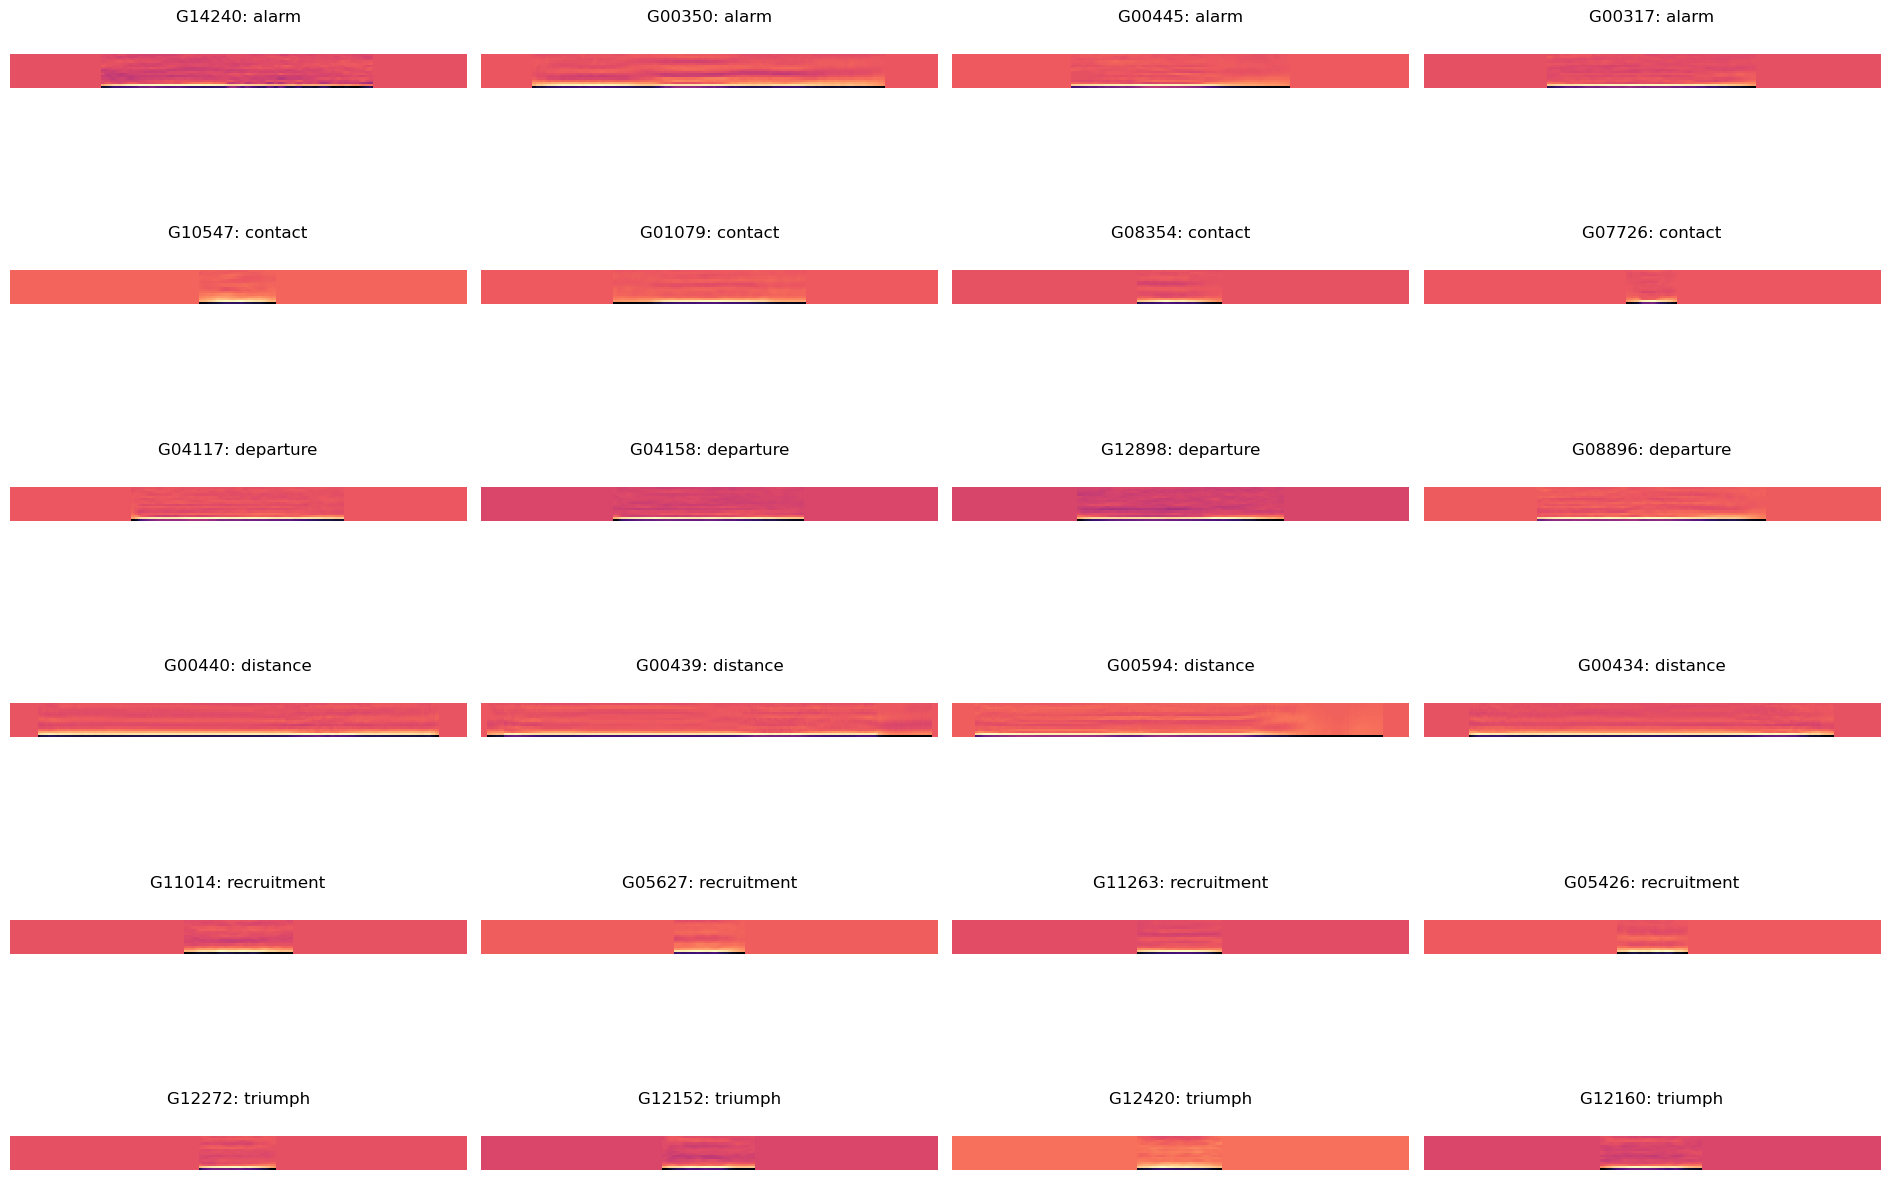

In [ ]:
subset_size = 4

subsample_sizes = {
  'recruitment': subset_size,
  'contact': subset_size,
  'departure': subset_size,
  'triumph': subset_size,
  'alarm': subset_size,
  'distance': subset_size,
}

# Randomly subsample per call type
def subsample_group(group):
  call_type = group.name  # Group name corresponds to call type
  if call_type in subsample_sizes:
    return group.sample(n=subsample_sizes[call_type]) #, random_state=44

# Group by type and apply subsampling
example_calls = calls_df.groupby('call_type', group_keys=False).apply(subsample_group)

fig, axes = plt.subplots(6, 4, figsize = (19, 14))

for i, (_, vocalization) in enumerate(example_calls.iterrows()):
  row = i // 4
  col = i % 4
  axes[row, col].matshow(vocalization["log_padded_lfccs"], origin="lower", cmap="magma")
  axes[row, col].set_title(f'{vocalization["clip_ID"]}: {vocalization["call_type"]}', )
  axes[row, col].axis("off") 
    
for i in range(len(sample_calls), 24):
  row = i // 4
  col = i % 4
  axes[row, col].axis("off")

plt.tight_layout()
plt.show()

In [179]:
# # export all spectrograms listed per type to pngs
# sorted_df = calls_df.sort_values(by=["call_type", "track_ID", "clip_ID"])

# for idx in range(0, len(sorted_df), 28):
#   fig, axes = plt.subplots(7, 4, figsize = (19, 14))
#   for i, vocalization in sorted_df.iloc[idx:idx+28].reset_index().iterrows():
#     row = i // 4
#     col = i % 4
#     axes[row, col].matshow(vocalization["log_padded_spectrogram"], origin="lower", cmap="magma")
#     axes[row, col].set_title(f'{vocalization["track_ID"]} - {vocalization["clip_ID"]}: {vocalization["call_type"]}')
#     axes[row, col].axis("off") 
      
#   for i in range(len(sample_calls), 28):
#     row = i // 4
#     col = i % 4
#     axes[row, col].axis("off")

#   plt.tight_layout()
#   #plt.show()
#   fig.savefig(f'spectrograms/{sorted_df.iloc[idx]["track_ID"]}_{sorted_df.iloc[idx+28]["track_ID"]}.png')

In [180]:
calls_df["log_padded_spectrogram"] = calls_df["log_padded_spectrogram"].apply(lambda x: json.dumps(x.tolist()))
calls_df["log_padded_lfccs"] = calls_df["log_padded_lfccs"].apply(lambda x: json.dumps(x.tolist()))

In [181]:
calls_df.drop(columns=["padded_spectrogram", "spectrogram", "log_duration", "normalized_log_length", "log_target_duration", ]).to_csv('features_and_spectrograms.csv', index=False)